Practice reading in HYCOM model data.

In [2]:
from __future__ import division

import netCDF4 as nc
import numpy as np


from salishsea_tools import (
    nc_tools)
import datetime
import os
import urllib2
from StringIO import StringIO
import pandas as pd
from dateutil import tz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from salishsea_tools import viz_tools
from salishsea_tools.nowcast import residuals, figures

%matplotlib inline

#HYCOM

The HYCOM model provides ssh forecasts. Data is saved at a 3 hourly frequency. We can access the HYCOM sea surface height at a url like this:

* http://nomads.ncep.noaa.gov:9090/dods/rtofs/rtofs_global20150716/rtofs_glo_2ds_forecast_3hrly_diag.ascii?ssh[0:64][0][1661:1662][1931:1932]

** Variables**
* time - measured in days since 1-1-1 00:00:0.0
* ssh - metres
* lat, lon don't have a lot of meta data

First, try to figure out if this data is the same as the NOAA forecast.

Below, I copied and pasted the data from the 2015-07-16 forecast page. I will compare this data with the Neah Bay forecasts with are collecting.

Reading in data

In [3]:
def read_url(date,i,j):
    """Reads text from a url and save the output to a file
    Returns the filename of the output file
    
    :arg date: the data of the download
    :type date: datetime object
    
    :arg i: the i index of the hycom grid
    :type i: integer
    
    :arg j: the j index of the hycom grid
    :type j: integer
    
    :returns: filename, the name of the file where the data was saved"""
    
    url = ('http://nomads.ncep.noaa.gov:9090/dods/rtofs/rtofs_global{}/rtofs_glo_2ds_forecast_3hrly_diag.ascii'
       '?ssh[0:64][0][{}][{}]'.format(date.strftime('%Y%m%d'),j,i))
    
    response = urllib2.urlopen(url)
    html = response.read()

    #We might want to save output like we do for neah bay
    directory = date.strftime('%Y-%m-%d')
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = '{}/hycom_{}_{}.txt'.format(directory,i,j)
    text_file = open(filename, "w")
    text_file.write(html)
    text_file.close()
    
    return filename

* Notice the first output for ssh is bizzare. 1276 m ??? 

In [9]:
def parse_hycom_text(filename):
    """Parses the text in a output file from the hycom model. 
    
    :arg filename: file where the hycom model data is stored
    :type filename: string
    
    :returns: data, lon, lat
    data is a data frame with ssh and time columns
    lon is the longitude of the hycom model point
    lat is the latitude of the hycom grid point 
    """
    ssh_read = False
    time_read = False
    lat_read = False
    lon_read = False
    #initialize variables
    sshs = []
    times = []
    lat=0
    lon=0
    
    #variable to define number of lines to skip
    skip_lines = 0
    with open(filename) as f:
        #loop through each line
        for line in f:
            # check if we should skip a line
            if skip_lines >0:
                skip_lines=skip_lines -1
                continue
                
            # read the line
            words = line.split()
            if words: #there is data in the line, do stuff with it  
                #if we should read a variable, read it
                #read ssh
                if ssh_read:
                    if words[0] =='time,': # check we are still in the ssh part
                        time_read = True
                        ssh_read = False
                    else:
                        sshs.append(float(words[1])) #append the ssh data t list
                        skip_lines = 2
                # read time
                elif time_read:
                    if words[0]=='lev,': # check we are still in the time part?
                        time_read = False
                    else:
                        times = words
                #read lat
                elif lat_read:
                    lat=float(words[0])
                    lat_read = False
                # read lon
                elif lon_read:
                    lon=float(words[0]) - 360 # subtract 360 for conersion to model coordinates
                
                #if we aren't reading a variable, check that we can determine which variable should be read next
                if words[0] =='ssh,':
                    ssh_read = True
                elif words[0] == 'time,':
                    time_read = True
                    ssh_read = False
                elif words[0] == 'lat,':
                    lat_read = True
                    time_read = False
                elif words[0] =='lon,':
                    lon_read= True
                    lat_read = False
    #finished reading the file

    #convert times to datetimes
    time_units = 'days since 1-1-1 00:00:0.0'
    for i, t in enumerate(times):
        t = float(t[:-1])
        times[i] = nc.num2date(t, time_units)
    # remove first ssh/times element because it is not real data
    sshs = sshs[1:]
    times = times[1:]
    
    #add the data to a data frame
    data = pd.DataFrame({'ssh': sshs, 'time': times})
        
    return data, lon, lat

#Compare with Neah Bay forecast and observations

(735807.0, 735813.0)

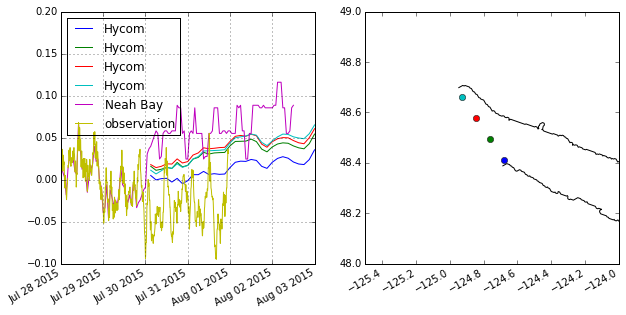

In [12]:
grid_b = nc.Dataset('/data/nsoontie/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')

fig,axs= plt.subplots(1,2,figsize=(10,5))
ax=axs[0]
axm=axs[1]
date = datetime.datetime(2015,7,30)

#Hycom
iss = np.arange(1934,1920,-1)
jss = np.arange(1661,1665)
for i,j in zip(iss,jss):
    #filename = read_url(date,i,j) read website
    filename = '/data/nsoontie/MEOPAR/analysis/Nancy/nowcast/{}/hycom_{}_{}.txt'.format(date.strftime('%Y-%m-%d'),i,j)
    data, lon, lat = parse_hycom_text(filename)
    ax.plot(data['time'],data['ssh'],label='Hycom')
    axm.plot(lon,lat,'o')
viz_tools.plot_coastline(axm,grid_b,coords='map')


#Neah Bay forecast
filename = '/ocean/nsoontie/MEOPAR/sshNeahBay/txt/sshNB_2015-07-29_18.txt'
NBdata = residuals._load_surge_data(filename)
surge, dates = residuals._retrieve_surge(NBdata, datetime.datetime(2015,7,20))
ax.plot(dates[:],surge[:],label = 'Neah Bay')

# Neah Bay observations
obs = figures.get_NOAA_wlevels(figures.SITES['Neah Bay']['stn_no'], '20-Jul-2015', '31-Jul-2015')
tides = figures.get_NOAA_tides(figures.SITES['Neah Bay']['stn_no'], '20-Jul-2015', '31-Jul-2015')

res = residuals.calculate_residual(obs.wlev, obs.time, tides.pred, tides.time)
ax.plot(obs.time,res,label='observation')


axm.set_xlim([-125.5,-124])
axm.set_ylim([48,49])
ax.legend(loc=0)
ax.grid()
fig.autofmt_xdate()
ax.set_xlim([datetime.datetime(2015,7,28),datetime.datetime(2015,8,3)])

At first glance, these models look very different! I need some more data points. Will need an longer time period for comparions with observations.
* We might be able to interpolate these points across our open boundary

#Compare between forecasts

Two forecasts are available each day. How different are they?

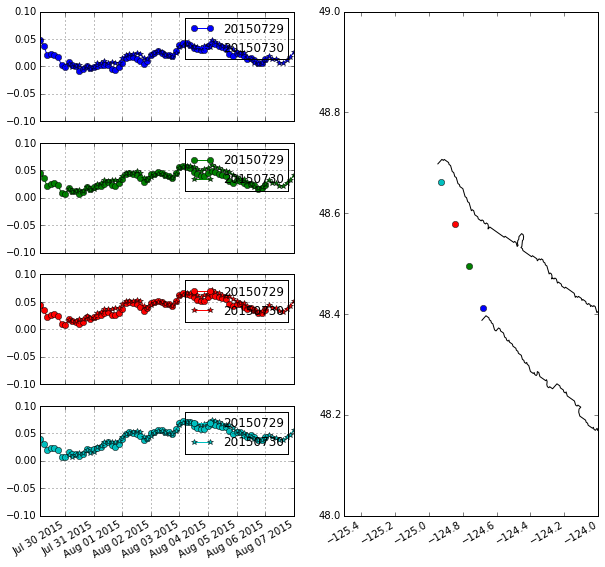

In [22]:
fig= plt.figure(figsize=(10,10))
axm=fig.add_subplot(1,2,2)

ax1=fig.add_subplot(4,2,1)
ax2=fig.add_subplot(4,2,3)
ax3=fig.add_subplot(4,2,5)
ax4=fig.add_subplot(4,2,7)
axs=[ax1,ax2,ax3,ax4]
colors=['b','g','r','c']

#first forecast
date = datetime.datetime(2015,7,29)
count=0
i = 1933
iss = np.arange(1934,1920,-1)
jss = np.arange(1661,1665)
for i,j, ax in zip(iss,jss, axs):
    filename = '/data/nsoontie/MEOPAR/analysis/Nancy/nowcast/{}/hycom_{}_{}.txt'.format(date.strftime('%Y-%m-%d'),i,j)
    data, lon, lat = parse_hycom_text(filename)
    ax.plot(data['time'],data['ssh'],marker='o',c=colors[count],label='{}'.format(date.strftime('%Y%m%d')))
    axm.plot(lon,lat,'o')
    count=count+1
viz_tools.plot_coastline(axm,grid_b,coords='map')

#second forecast
date = datetime.datetime(2015,7,30)
count=0
i = 1933
iss = np.arange(1934,1920,-1)
jss = np.arange(1661,1665)
for i,j,ax in zip(iss,jss,axs):
    filename = '/data/nsoontie/MEOPAR/analysis/Nancy/nowcast/{}/hycom_{}_{}.txt'.format(date.strftime('%Y-%m-%d'),i,j)
    data, lon, lat = parse_hycom_text(filename)
    ax.plot(data['time'],data['ssh'],marker='*',c=colors[count],label='{}'.format(date.strftime('%Y%m%d')))
    count=count+1
    ax.legend()
    ax.grid()
    ax.set_ylim([-.1,.1])

axm.set_xlim([-125.5,-124])
axm.set_ylim([48,49])

fig.autofmt_xdate()

Need to save this data daily. That might mean changing the name of the text files or writing in some other file format.

Right now all of the text files have the same name.

I don't think there is any need to look at the further in the future forecast.

Notes: 
* Hycom model files don't change day to change day to day. For example, if on Jul 21 I look at Hycom July 22 results, that will be the same if I looked at July 22 results on July 22. 

Potential difficulties: 
* HYCOM doesn't have any observations. What do we use for nowcast? We might have to use a combination of neah bay and hycom. (but it has nowcasts)

